In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

Загрузка синтезированных данных

In [ ]:
water_consump_hot = pd.read_csv('/content/drive/MyDrive/LDT_2025/water_consump_hot.csv')

In [ ]:
water_consump_hot['time_5min'] = pd.to_datetime(water_consump_hot['time_5min'] )

In [ ]:
water_consump_hot.head()

,id_house,time_5min,water_consumption,noise_hot,water_hot
0,0,2025-09-01 00:00:00,0.231,-0.000615,0.231
1,0,2025-09-01 00:05:00,0.226,-0.011810,0.223
2,0,2025-09-01 00:10:00,0.188,0.023142,0.192
3,0,2025-09-01 00:15:00,0.164,0.000301,0.164
4,0,2025-09-01 00:20:00,0.205,0.010872,0.207


In [ ]:
water_consump_hot.columns

Index(['id_house', 'time_5min', 'water_consumption', 'noise_hot', 'water_hot'], dtype='object')

In [ ]:
water_0 = water_consump_hot[(water_consump_hot['id_house']==0)&(water_consump_hot['time_5min']<pd.to_datetime('2025-10-03 00:00:00'))][['time_5min','water_consumption']]

### Используем пакет Prophet для прогнозирования временного ряда

In [ ]:
# Преобразуем в формат для Prophet
def prepare_for_prophet(water_df):
    """
    Подготовка данных для Prophet
    Prophet требует колонки ds (datetime) и y (значение)
    """
    df = water_df.copy()
    df.columns = ['ds', 'y']
    return df

# Подготовка данных
prophet_df = prepare_for_prophet(water_0)

# Разделение на train/test (последние 7 дней для теста)
train_size = len(prophet_df) - 7 * 24 * 12  # 7 дней * 24 часа * 12 интервалов
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Train period: {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Test period: {test_df['ds'].min()} - {test_df['ds'].max()}")

Train size: 7200
Test size: 2016
Train period: 2025-09-01 00:00:00 - 2025-09-25 23:55:00
Test period: 2025-09-26 00:00:00 - 2025-10-02 23:55:00


Подобрал параметры

In [ ]:
# Создание и обучение модели
model = Prophet(
    daily_seasonality=True,    # суточная сезонность
    weekly_seasonality=True,   # недельная сезонность
    yearly_seasonality=False,  # годовая не нужна для коротких рядов
    changepoint_prior_scale=0.05,  # гибкость тренда
    seasonality_prior_scale=20.0   # сила сезонности
)

# Добавляем  сезонность для более точной суточной сезонности
model.add_seasonality(
    name='daily_detailed',
    period=1,
    fourier_order=30,  # высокая точность для 5-минутных данных
    prior_scale=15.0
)

model.add_seasonality(
    name='weekly_detailed',
    period=7,
    fourier_order=20,                  # ↑ Для недельной сезонности
    prior_scale=15.0
)
# Обучение модели
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp18bnp200/o17tk2ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp18bnp200/aeju77oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49382', 'data', 'file=/tmp/tmp18bnp200/o17tk2ap.json', 'init=/tmp/tmp18bnp200/aeju77oz.json', 'output', 'file=/tmp/tmp18bnp200/prophet_modelj8rnfuxo/prophet_model-20251002083804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Создание фрейма для прогноза
future = model.make_future_dataframe(periods=len(test_df), freq='5min', include_history=True)

# Прогнозирование
forecast = model.predict(future)

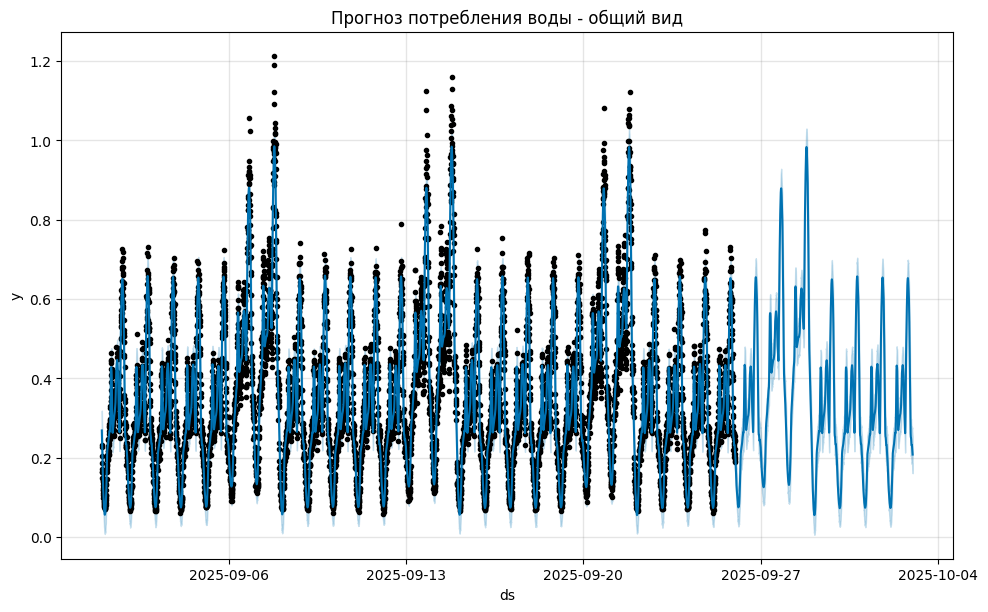

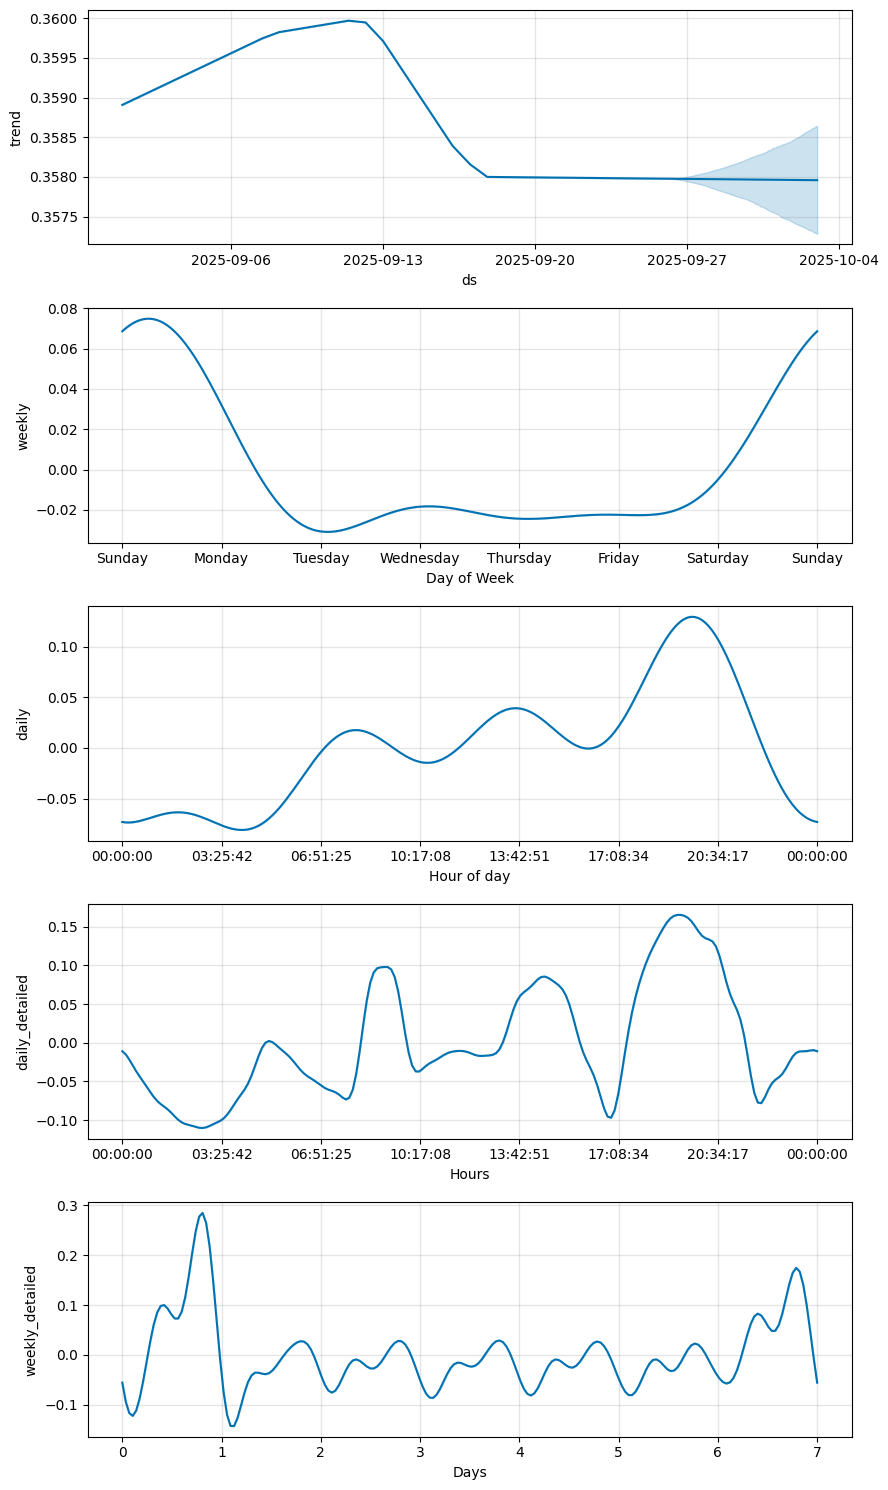

In [ ]:
# Визуализация результатов
fig1 = model.plot(forecast)
plt.title('Прогноз потребления воды - общий вид')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

Оценка качества модели на ООТ

In [ ]:
# Оценка на тестовой выборке
test_forecast = forecast.iloc[train_size:].set_index('ds')['yhat']
test_actual = test_df.set_index('ds')['y']

# Метрики качества
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_actual, test_forecast)
rmse = np.sqrt(mean_squared_error(test_actual, test_forecast))
mape = np.mean(np.abs((test_actual - test_forecast) / test_actual)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.0273
RMSE: 0.0387
MAPE: 7.80%


качество после подбора улучшилось

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,weekly_detailed,weekly_detailed_lower,weekly_detailed_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-09-01 00:00:00,0.358909,0.223114,0.318818,0.358909,0.358909,-0.090028,-0.090028,-0.090028,-0.073041,...,0.031948,0.031948,0.031948,-0.038032,-0.038032,-0.038032,0.0,0.0,0.0,0.268880
1,2025-09-01 00:05:00,0.358909,0.212222,0.306105,0.358909,0.358909,-0.099890,-0.099890,-0.099890,-0.073388,...,0.031615,0.031615,0.031615,-0.044636,-0.044636,-0.044636,0.0,0.0,0.0,0.259019
2,2025-09-01 00:10:00,0.358909,0.202404,0.290134,0.358909,0.358909,-0.110706,-0.110706,-0.110706,-0.073550,...,0.031282,0.031282,0.031282,-0.051072,-0.051072,-0.051072,0.0,0.0,0.0,0.248203
3,2025-09-01 00:15:00,0.358910,0.190473,0.280190,0.358910,0.358910,-0.122152,-0.122152,-0.122152,-0.073544,...,0.030948,0.030948,0.030948,-0.057332,-0.057332,-0.057332,0.0,0.0,0.0,0.236757
4,2025-09-01 00:20:00,0.358910,0.178508,0.272392,0.358910,0.358910,-0.133751,-0.133751,-0.133751,-0.073385,...,0.030614,0.030614,0.030614,-0.063409,-0.063409,-0.063409,0.0,0.0,0.0,0.225159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9211,2025-10-02 23:35:00,0.357959,0.169794,0.265035,0.357285,0.358645,-0.139708,-0.139708,-0.139708,-0.068033,...,-0.022355,-0.022355,-0.022355,-0.038395,-0.038395,-0.038395,0.0,0.0,0.0,0.218251
9212,2025-10-02 23:40:00,0.357959,0.168074,0.263691,0.357284,0.358645,-0.142637,-0.142637,-0.142637,-0.069513,...,-0.022359,-0.022359,-0.022359,-0.040158,-0.040158,-0.040158,0.0,0.0,0.0,0.215322
9213,2025-10-02 23:45:00,0.357959,0.166573,0.260374,0.357284,0.358645,-0.145051,-0.145051,-0.145051,-0.070742,...,-0.022362,-0.022362,-0.022362,-0.041910,-0.041910,-0.041910,0.0,0.0,0.0,0.212908
9214,2025-10-02 23:50:00,0.357959,0.167285,0.256947,0.357284,0.358646,-0.147303,-0.147303,-0.147303,-0.071731,...,-0.022366,-0.022366,-0.022366,-0.043650,-0.043650,-0.043650,0.0,0.0,0.0,0.210656


### Далее делаем функции для прогнозирования всех 2200 домов района Люблино

In [ ]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

def forecast_single_house(df_house, days_forecast=7, output_dir="forecasts"):
    """Прогнозирование для одного дома с сохранением в отдельный файл"""
    try:
        # Создаем папку если нет
        os.makedirs(output_dir, exist_ok=True)

        # Подготовка данных для Prophet
        prophet_df = df_house[['time_5min', 'water_consumption']].copy()
        prophet_df.columns = ['ds', 'y']

        house_id = df_house['id_house'].iloc[0]

            # Создаем и обучаем модель
        model = Prophet(
            daily_seasonality=True,    # суточная сезонность
            weekly_seasonality=True,   # недельная сезонность
            yearly_seasonality=False,  # годовая не нужна для коротких рядов
            changepoint_prior_scale=0.05,  # гибкость тренда
            seasonality_prior_scale=20.0   # сила сезонности
        )

        # Добавляем  сезонность для более точной суточной сезонности
        model.add_seasonality(
            name='daily_detailed',
            period=1,
            fourier_order=30,
            prior_scale=15.0
        )
        # Для недельной сезонности
        model.add_seasonality(
            name='weekly_detailed',
            period=7,
            fourier_order=20,
            prior_scale=15.0
        )

        model.fit(prophet_df)

        # Создаем фрейм для прогноза
        future = model.make_future_dataframe(
            periods=days_forecast * 24 * 12,
            freq='5min',
            include_history=False
        )

        # Прогнозирование
        forecast = model.predict(future)

        # Добавляем id дома
        forecast['id_house'] = house_id

        # Сохраняем прогноз для этого дома в отдельный файл
        output_file = os.path.join(output_dir, f"house_{house_id}_forecast.csv")
        forecast[['id_house', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(output_file, index=False)

        return output_file

    except Exception as e:
        print(f"Ошибка для дома {df_house['id_house'].iloc[0]}: {e}")
        return None

In [ ]:
def batch_forecast_save_separate(start_forecast, house_ids, input_file, output_dir="house_forecasts", days_forecast=7):
    """Пакетное прогнозирование с сохранением по отдельным файлам"""

    df = pd.read_csv(input_file)
    df['time_5min'] = pd.to_datetime(df['time_5min'])
    df = df[df['time_5min'] < pd.to_datetime(start_forecast)]

    # прогноз только по домам из списка house_ids
    houses = df['id_house'].unique()
    new_ids =[]
    for h in houses:
      if h in house_ids:
        new_ids.append(h)
    new_ids.sort()
    print(f"Кол-во домов для прогноза: {len(new_ids)}")

    # Создаем папку для результатов
    os.makedirs(output_dir, exist_ok=True)

    # Прогнозирование для каждого дома
    successful_forecasts = 0

    for house_id in tqdm(new_ids, desc="Прогнозирование"):
        house_data = df[df['id_house'] == house_id].copy()
        house_data = house_data.sort_values('time_5min')

        # Прогнозируем и сохраняем в отдельный файл
        result_file = forecast_single_house(house_data, days_forecast, output_dir)

        if result_file is not None:
            successful_forecasts += 1

    print(f"Успешно прогнозировано: {successful_forecasts} домов")
    print(f"Файлы сохранены в папку: {output_dir}")

    return successful_forecasts

Делаю прогноз со 2 окт на 18 дней вперед для 2215 домов

In [ ]:
l=[]
for i in range(2215):
  l.append(i)

In [ ]:
batch_forecast_save_separate('2025-10-02 00:00:00', l, '/content/drive/MyDrive/LDT_2025/water_consump_hot.csv', '/content/drive/MyDrive/LDT_2025/water_forecast', days_forecast=18)

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/LDT_2025/water_forecast/house_1_forecast.csv')

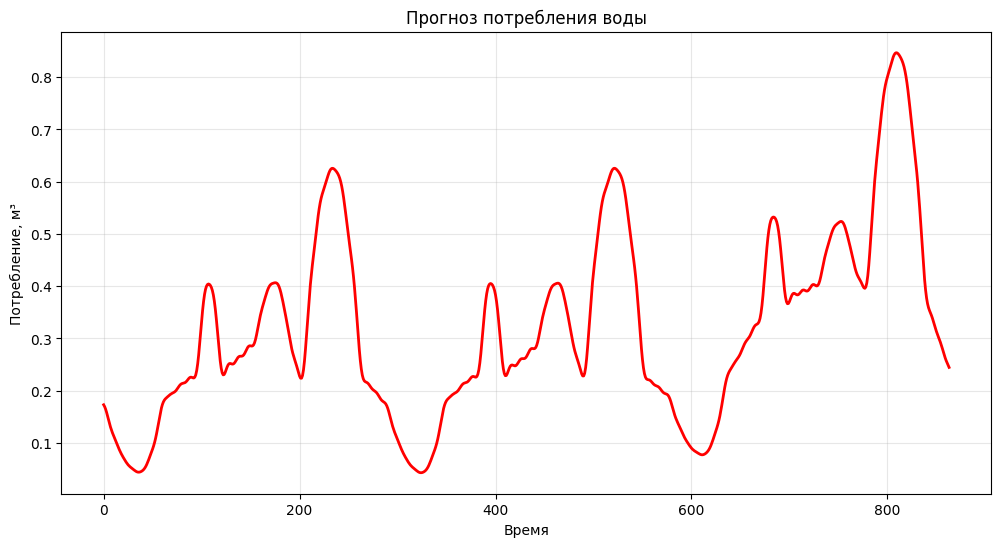

In [ ]:
ax = a['yhat'].plot(figsize=(12, 6), linewidth=2, color='green')
ax.set_title('Прогноз потребления воды')
ax.set_ylabel('Потребление, м³')
ax.set_xlabel('Время')
ax.grid(True, alpha=0.3)
plt.show()